<a href="https://colab.research.google.com/github/Charitonos/Tracking-Yolo/blob/main/ByteTrack_%26_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ByteTrack and YOLO
----

This notebook will be used to run YOLO (object detection) and ByteTrack & Supervision (for object tracking)

In [ ]:
!nvidia-smi

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

This cell is to download vdieos of the web

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

Edit this to set up the video for tracking

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/Mall.mkv"

Install utralytics for YOLO and import

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.149 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.6/78.2 GB disk)


In [ ]:
!pip install super_gradients
!pip install -r nas_req.txt
from super_gradients.training import models
from super_gradients.common.object_names import Models
from super_gradients.training.models.detection_models.customizable_detector import CustomizableDetector
from super_gradients.training.pipelines.pipelines import DetectionPipeline

Then we clone the repository for the tracker

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

#Choose the desired detection algorithm

Run only the cells under the desired detection algorithm to select

#Yolov8

Yolov8 models:

---
- yolov8n -> nano
- yolov8s -> small
- yolov8m -> medium
- yolov8l -> large
- yolov8x -> huge

---



In [ ]:
# settings
MODEL = "yolov8x.pt"
yolo_model = "v8"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()


100%|██████████| 131M/131M [00:00<00:00, 166MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients


#YOLO-NAS

YOLO-NAS models:

---
- yolo_nas_s -> small
- yolo_nas_m -> medium
- yolo_nas_l -> large
---

In [ ]:
# select model
MODEL = "yolo_nas_l"
yolo_model = "NAS"

In [ ]:
!pip install torchreid
!pip install torchvision
!pip install torch

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Select the detection model
model = models.get("yolo_nas_l" , pretrained_weights="coco").to(device)

# Switch from training to evaluation or inference
model.eval()

In [ ]:
# get frame info for tracker and video saving
h,w = (720,1280)
h2,w2 = h // 2 , w // 2

img_info = (h,w)
img_size = (h2,w2)

# This function is handling the dection preedictions
# We provide the detection we got using YOLO-NAS
# It will preprocess that input. Then convert it to a torch tensor.The torch
# tensor will become the input to the model. Lastly it will decode the output
def get_prediction(image_in, pipeline):
    # '''' Obtains DetectionPrediction object from a single input RGB image''''
    # Preprocess
    preprocessed_image, processing_metadata = pipeline.image_processor.preprocess_image(image = image_in.copy())

    # Predict
    with torch.no_grad():
        torch_input = torch.Tensor(preprocessed_image).unsqueeze(0).to(device)
        model_output = model(torch_input)
        prediction = pipeline._decode_model_output(model_output , model_input = torch_input)

    # Postprocess
    return pipeline.image_processor.postprocess_predictions(predictions = prediction[0], metadata=processing_metadata)

In [ ]:
pipeline = DetectionPipeline(
    model=model,
    image_processor=model._image_processor,
    post_prediction_callback=model.get_post_prediction_callback(iou=0.55, conf=0.2),
    class_names=model._class_names,
)

# COCO Classes
---
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
  
  ---


In [ ]:
# dict maping class_id to class_name
if yolo_model == "v8":
    CLASS_NAMES_DICT = model.model.names

if yolo_model == "NAS":
    CLASS_NAMES_DICT = model._class_names

# class_ids of intrest - person
CLASS_ID = [0]

DetectionPrediction(bboxes_xyxy=array([[     22.177,      530.76,      94.018,      659.39],
       [     443.85,      433.14,       496.8,      569.31],
       [     500.33,      301.08,      548.92,      416.97],
       [     940.57,      469.83,      1015.2,      592.83],
       [     759.97,      337.87,      807.09,      439.43],
       [     963.96,      213.64,      1010.8,      324.11],
       [     974.92,      315.85,      1028.9,      430.33],
       [     173.25,      293.11,      220.84,      407.74],
       [     760.37,      634.52,      829.35,      719.53],
       [     470.02,      160.14,      511.55,      259.65],
       [     618.36,      115.77,      658.58,      204.82],
       [     378.69,      182.03,      419.06,      274.68],
       [     802.19,      84.952,      836.02,      178.25],
       [     229.55,      330.98,      266.78,      428.18],
       [     63.639,      88.347,      96.617,      167.87],
       [     379.63,      134.79,      412.36,      1

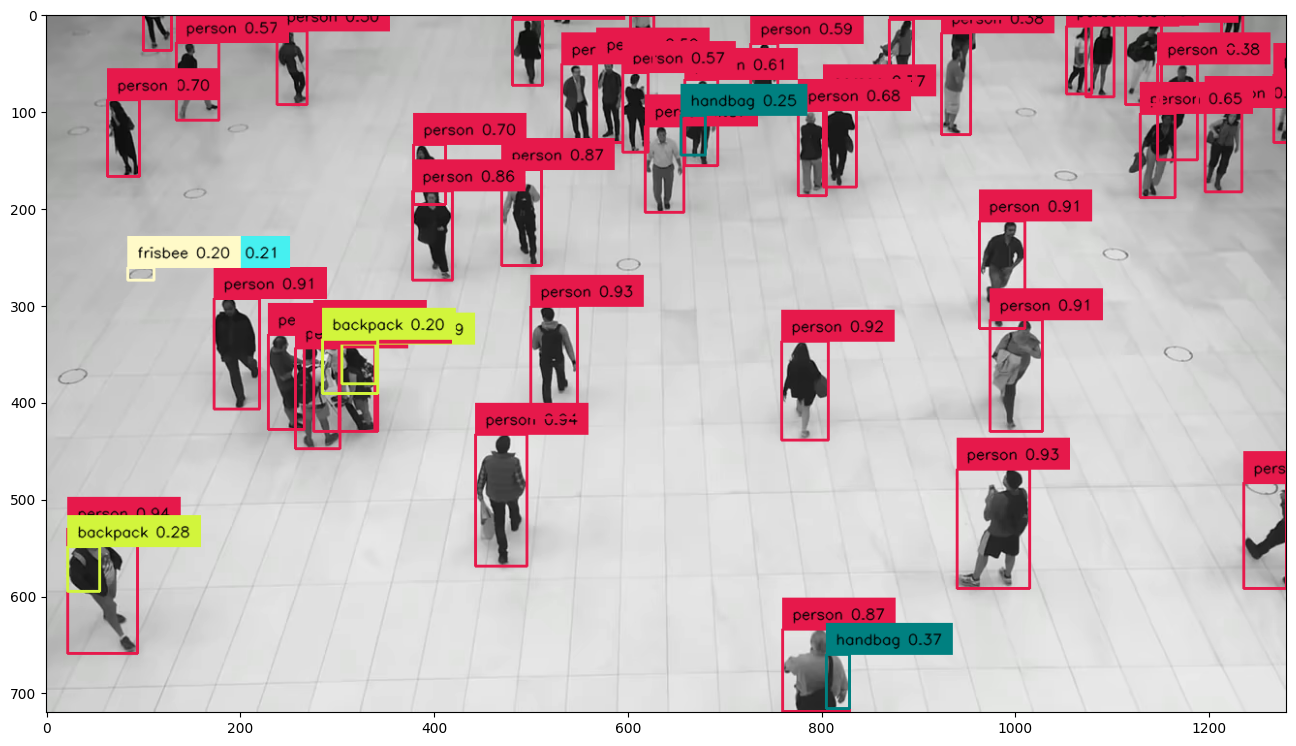

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)

# acquire first video frame
iterator = iter(generator)
frame = next(iterator)

# model prediction on single frame and conversion to supervision Detections
if yolo_model == "v8":

    # Detect objects in the frame
    results = model(frame)

    # Break down the detections
    detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

if yolo_model == "NAS":
    # Detect objects in the frame
    results = get_prediction(frame , pipeline)

    # checking the structure of results
    print(results)

    # Break down the detections
    detections = Detections(
    xyxy=results.bboxes_xyxy,
    confidence=results.confidence,
    class_id=results.labels.astype(int)
)

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

This determines the location of the output

In [ ]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/Output.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
#VideoInfo.from_video_path(f"{HOME}/vehicle-counting.mp4")

VideoInfo(width=1280, height=720, fps=25, total_frames=343)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())

# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):

        # model prediction on single frame and conversion to supervision Detections
        # Use this detection method if detector is yolov8
        if yolo_model == "v8":
            results = model(frame)

            detections = Detections(
                xyxy=results[0].boxes.xyxy.cpu().numpy(),
                confidence=results[0].boxes.conf.cpu().numpy(),
                class_id=results[0].boxes.cls.cpu().numpy().astype(int)
            )

        # Use this detection method if detector is YOLO-NAS
        if yolo_model == "NAS":
            results = get_prediction(frame , pipeline)

            # Break down the detections
            detections = Detections(
            xyxy=results.bboxes_xyxy,
            confidence=results.confidence,
            class_id=results.labels.astype(int)
        )

        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        # updating line counter
        line_counter.update(detections=detections)

        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/343 [00:00<?, ?it/s]